<a href="https://colab.research.google.com/github/jiali25/Design-of-a-system-for-the-analysis-of-reverberant-acoustic-environments-using-Deep-Learning/blob/master/1st_part_of_the_analysis_of_reverberation_with_reverberant_audios_using_Mel_Filter_Banks%2C_STFT_and_MFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Acceso a Google Drive**

In [31]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
ls '/content/drive/My Drive/'

'Colab Notebooks'/   Documentos/   foo.txt   REVER/   REVERBERADOS/   TIMIT/


In [33]:
cd '/content/drive/My Drive/TIMIT'

/content/drive/My Drive/TIMIT


In [34]:
ls

__MACOSX/     TEST_SIN_SA.zip  TIMIT-20200324T163854Z-001.zip  train+test.zip
TEST_SIN_SA/  TIMIT/           Train_IR1/


In [0]:
# Copiar la carpeta de train de TIMIT
!cp TIMIT-20200324T163854Z-001.zip /content/

In [36]:
cd /content/

/content


In [37]:
ls

drive/  sample_data/  TIMIT/  TIMIT-20200324T163854Z-001.zip


In [38]:
! unzip TIMIT-20200324T163854Z-001.zip

Archive:  TIMIT-20200324T163854Z-001.zip
replace TIMIT/doc/SPKRINFO.TXT? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [39]:
# Importar biblioteca Librosa
import librosa
print(librosa.__version__)

0.6.3


In [40]:
# Cargar el archivo y mostrar el número de muestras, la frecuencia de muestreo y la duración en segundos
filename='./TIMIT/train/dr1/fmem0/sx333.wav'
y_or, sr = librosa.load(filename, sr=16000)
print(len(y_or), sr, ' Duracion en segundos: ', len(y_or)/sr)

82228 16000  Duracion en segundos:  5.13925


In [41]:
# Audio widget para reproducir la voz
from IPython.display import Audio

Audio(data=y_or, rate=sr)

In [42]:
# Transcripción de la frase 
! cat ./TIMIT/train/dr1/fmem0/sx333.txt

0 82228 An adult male baboon's teeth are not suitable for eating shellfish.


In [43]:
# Transcripción de fonemas con el límite en muestras
! cat ./TIMIT/train/dr1/fmem0/sx333.phn

0 3520 h#
3520 3940 q
3940 5045 ae
5045 6051 n
6051 7586 q
7586 9399 ae
9399 10001 dx
10001 10945 ah
10945 12323 l
12323 13840 tcl
13840 15009 pau
15009 16106 m
16106 18422 ey
18422 20219 l
20219 21919 pau
21919 22181 b
22181 24271 ae
24271 25817 bcl
25817 26100 b
26100 28532 uw
28532 29890 n
29890 31910 z
31910 32917 tcl
32917 34798 t
34798 37000 iy
37000 39560 th
39560 40427 pau
40427 41166 q
41166 41608 ax
41608 42527 r
42527 44620 n
44620 46876 aa
46876 47760 tcl
47760 48773 pau
48773 51440 s
51440 52880 ux
52880 53440 dx
53440 54160 ax
54160 54976 bcl
54976 55530 b
55530 57046 el
57046 59133 f
59133 60248 er
60248 62240 q
62240 63210 iy
63210 63917 dx
63917 64878 iy
64878 66236 ng
66236 69431 sh
69431 70856 eh
70856 72176 l
72176 74783 f
74783 76402 ih
76402 79744 sh
79744 82160 h#


In [0]:
# Importar bibliotecas
import os
import sys
import shutil
import re
import librosa
import numpy as np
from scipy.io.wavfile import write
from scipy.io import loadmat
from scipy import signal
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
ls /content/drive/'My Drive'/REVER

 air_binaural_aula_carolina_0_1_1_90_3.mat
 air_binaural_aula_carolina_0_1_3_135_3.mat
 air_binaural_aula_carolina_0_1_3_180_3.mat
 air_binaural_aula_carolina_0_1_6_90_3.mat
 air_binaural_aula_carolina_1_1_3_180_3.mat
 air_binaural_aula_carolina_1_1_3_45_3.mat
 air_binaural_aula_carolina_1_1_4_90_3.mat
 air_binaural_aula_carolina_1_1_6_90_3.mat
 air_binaural_booth_0_0_1.mat
 air_binaural_booth_0_0_3.mat
 air_binaural_booth_0_1_1.mat
 air_binaural_booth_1_0_1.mat
 air_binaural_booth_1_0_2.mat
 air_binaural_booth_1_0_3.mat
 air_binaural_booth_1_1_1.mat
 air_binaural_booth_1_1_2.mat
 air_binaural_booth_1_1_3.mat
 air_binaural_lecture_0_1_1.mat
 air_binaural_lecture_0_1_6.mat
 air_binaural_lecture_1_0_1.mat
'air_binaural_lecture_1_0_3(1).mat'
 air_binaural_lecture_1_0_3.mat
 air_binaural_lecture_1_0_4.mat
 air_binaural_lecture_1_0_6.mat
 air_binaural_lecture_1_1_1.mat
 air_binaural_lecture_1_1_3.mat
 air_binaural_lecture_1_1_6.mat
 air_binaural_meeting_0_1_1.mat
 air_binaural_meeting_0_1_3

In [0]:
# Copiar la RIR que se quiera procesar con el audio
!cp /content/drive/'My Drive'/REVER/air_binaural_lecture_1_1_6.mat .

In [0]:
# Cargar la RIR
IR_file = 'air_binaural_lecture_1_1_6.mat'
IR_data = loadmat(IR_file, squeeze_me=True, struct_as_record=False)
IR = IR_data['h_air']
air_info = IR_data['air_info']

In [48]:
air_info.filename

'air_lecture_1_1_6.mat'

In [49]:
air_info.room

'lecture'

In [0]:
fs_ori = air_info.fs

In [0]:
IR = librosa.resample(IR, fs_ori, 16000)

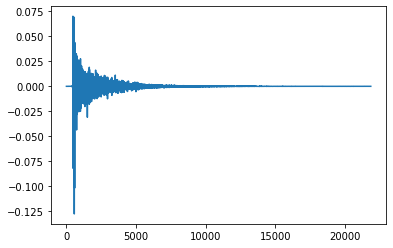

In [52]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(IR)

# **Reverberación del audio con convolución**

In [0]:
# Reverberación
# Normalización de la RIR
IR=IR/np.abs(np.max(IR))
p_max=np.argmax(np.abs(IR))
 
audio_aug = signal.fftconvolve(y_or, IR, mode='full')

# TRIM audio para suprimir el silencio final del audio
audio_aug, index = librosa.effects.trim(audio_aug, top_db=40)
            
y = np.int16(audio_aug/np.max(np.abs(audio_aug)) 
                                 * 32767* (np.random.rand(1)*3+7)/10)

In [54]:
# Descargar este audio y subirlo a la carpeta "REVERBERADOS"
# Reproducir el audio
Audio(data=y, rate=sr)

In [55]:
ls '/content/drive/My Drive/'

'Colab Notebooks'/   Documentos/   foo.txt   REVER/   REVERBERADOS/   TIMIT/


In [56]:
cd '/content/drive/My Drive/REVERBERADOS'

/content/drive/My Drive/REVERBERADOS


In [57]:
ls

fmem0_sx333_lecture.wav         mdpk0_sx333_lecture.wav
fmem0_sx333_meeting.wav         mdpk0_sx333_meeting.wav
fricativa_reverb_lecture_f.wav  vocal_reverb_lecture_f.wav
fricativa_reverb_lecture_m.wav  vocal_reverb_lecture_m.wav


In [0]:
!cp fmem0_sx333_lecture.wav  /content/

In [59]:
filename='./fmem0_sx333_lecture.wav'
y, sr = librosa.load(filename, sr=16000)
Audio(data=y, rate=sr)

# Imprimir la señal original y la filtrada

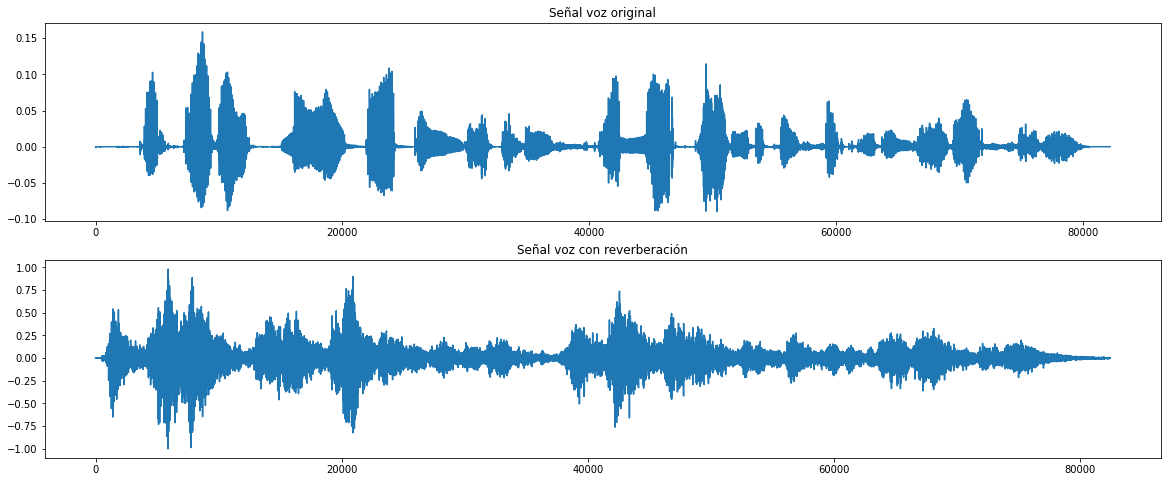

In [60]:
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Señal voz original')
plt.plot(y_or)
plt.subplot(212)
plt.title('Señal voz con reverberación')
plt.plot(y)

# **Espectrograma Mel**

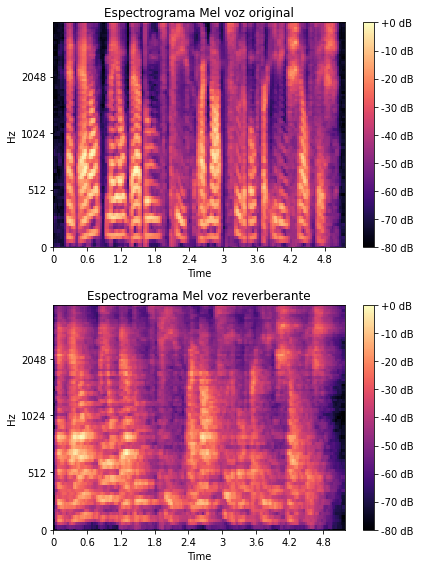

In [61]:
import librosa.display
MelS = librosa.feature.melspectrogram(y_or, sr=sr, n_fft=2048, \
                                      fmin=20, fmax=4000, n_mels=80)

MelS_reverb = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, \
                                      fmin=20, fmax=4000, n_mels=80)




plt.figure(figsize=(6, 8))
plt.subplot(211)
librosa.display.specshow(librosa.power_to_db(MelS, ref=np.max), y_axis='mel', fmax=4000, x_axis='time', hop_length=512, sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma Mel voz original')
plt.tight_layout()

plt.subplot(212)
librosa.display.specshow(librosa.power_to_db(MelS_reverb, ref=np.max), y_axis='mel', fmax=4000, x_axis='time', hop_length=512, sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma Mel voz reverberante')
plt.tight_layout()


In [62]:
MelS.shape

(80, 161)

In [0]:
# Para dibujar el eje de frecuencia
sample_rate=sr
nfilt=80
NFFT=2048
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt )  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz


In [0]:
# Cálculo LTAS
import librosa.display

LTAS_MelS = np.mean(librosa.power_to_db(MelS), axis=1)
LTAS_MelS_reverb = np.mean(librosa.power_to_db(MelS_reverb), axis=1)

Text(0.5, 0, 'Hz')

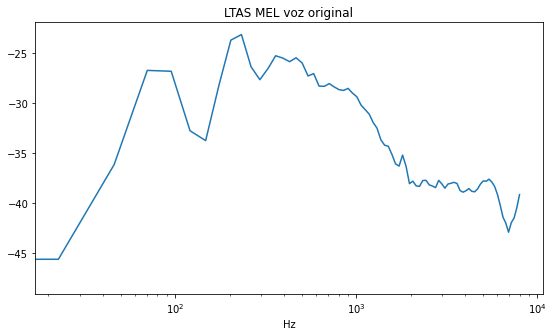

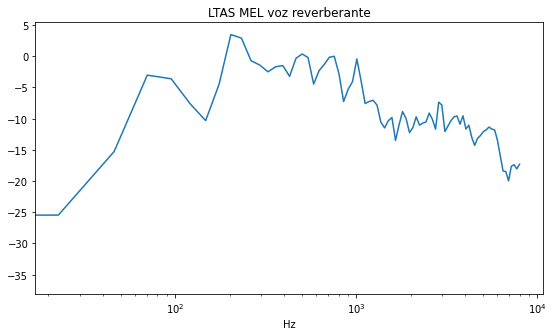

In [65]:
# Imprimir en pantalla las señales
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("LTAS MEL voz original")
plt.plot(hz_points, LTAS_MelS)
plt.xscale("log")
plt.xlabel('Hz')

plt.figure(figsize=(20,5))
plt.subplot(122)
plt.title("LTAS MEL voz reverberante")
plt.plot(hz_points, LTAS_MelS_reverb)
plt.xscale("log")
plt.xlabel('Hz')

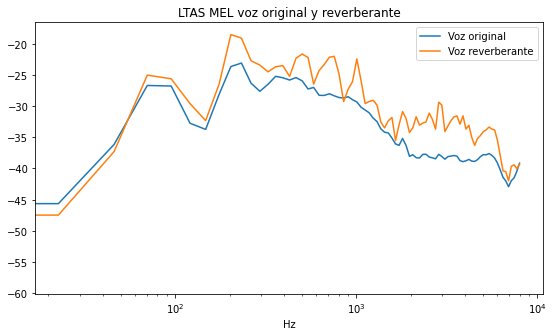

In [66]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("LTAS MEL voz original y reverberante")
plt.plot(hz_points, LTAS_MelS, label="Voz original")
plt.plot(hz_points, LTAS_MelS_reverb -22, label="Voz reverberante")
plt.xscale("log")
plt.xlabel('Hz')
plt.legend(loc='upper right')


# **STFT**

In [0]:
stft = librosa.amplitude_to_db(np.abs(librosa.stft(y_or, n_fft=2048)), ref=np.max)
stft_reverb = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=2048)), ref=np.max)

In [68]:
stft[:,0].shape

(1025,)

In [69]:
np.linspace(1, 10, 10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [70]:
(sr//2)//stft.shape[0]

7

In [0]:
# Para dibujar el eje de frecuencia
yfreq = np.linspace(0.0, sr//2, stft.shape[0])

In [72]:
yfreq

array([0.0000000e+00, 7.8125000e+00, 1.5625000e+01, ..., 7.9843750e+03,
       7.9921875e+03, 8.0000000e+03])

In [73]:
yfreq.shape

(1025,)

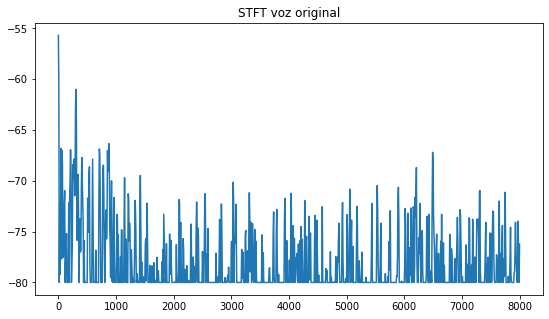

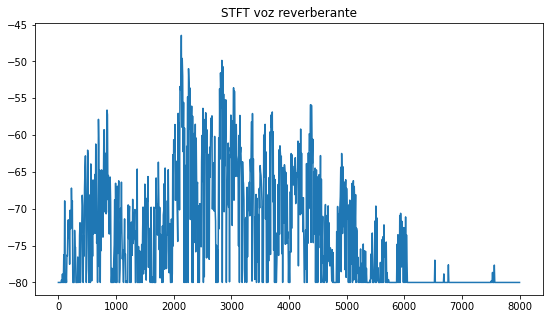

In [74]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("STFT voz original")
plt.plot(yfreq,stft[:,0])


plt.figure(figsize=(20,5))
plt.subplot(122)
plt.title("STFT voz reverberante")
plt.plot(yfreq,stft_reverb[:,0])


In [0]:
# Cálculo LTAS
LTAS_stft = np.mean(stft, axis=1)
LTAS_stft_reverb = np.mean(stft_reverb, axis=1)

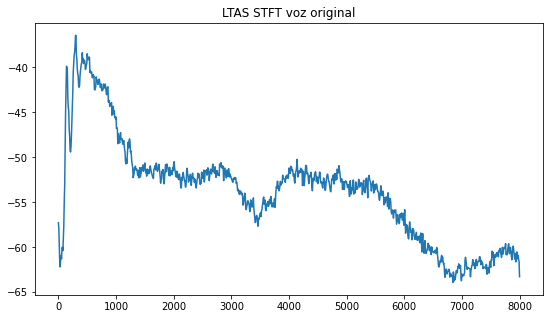

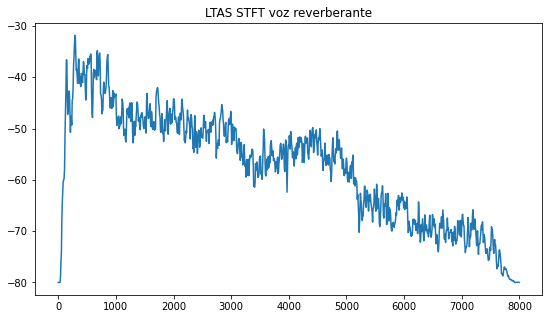

In [76]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("LTAS STFT voz original")
plt.plot(yfreq, LTAS_stft)


plt.figure(figsize=(20,5))
plt.subplot(122)
plt.title("LTAS STFT voz reverberante")
plt.plot(yfreq, LTAS_stft_reverb)

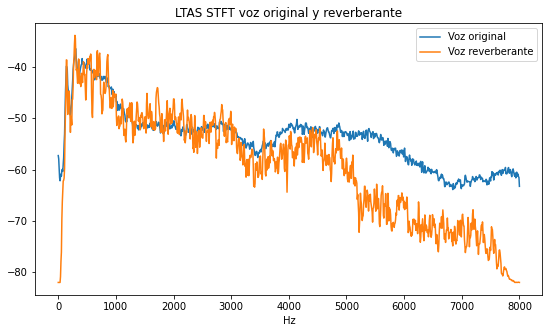

In [77]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("LTAS STFT voz original y reverberante")
plt.plot(yfreq, LTAS_stft, label="Voz original")
plt.plot(yfreq, LTAS_stft_reverb -2, label="Voz reverberante")
plt.xlabel('Hz')
plt.legend(loc='upper right')

Text(0.5, 0, 'Hz')

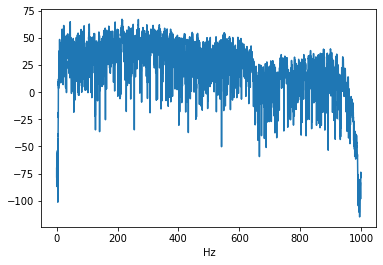

In [78]:
# H(w) haciendo la DFT de toda la RIR

from scipy.fft import fft

DFT_IR = 20*np.log(np.abs(fft(IR)))

# Lo ajusto para que quede también en la misma escala del eje de frecuencias (1000 Hz)

yfreq2 = np.linspace(0.0, 1000, len(DFT_IR)//2)
plt.plot(yfreq2, DFT_IR[0:len(DFT_IR)//2])
plt.xlabel('Hz')

# **MFCC**

In [0]:
import librosa.display

mfccs_or=librosa.feature.mfcc(y_or, sr=sr, n_fft=2048, dct_type = 3,  \
                        fmin=20, fmax=4000, n_mels=64, n_mfcc=40)

mfccs=librosa.feature.mfcc(y, sr=sr, n_fft=2048, dct_type = 3,  \
                        fmin=20, fmax=4000, n_mels=64, n_mfcc=40)

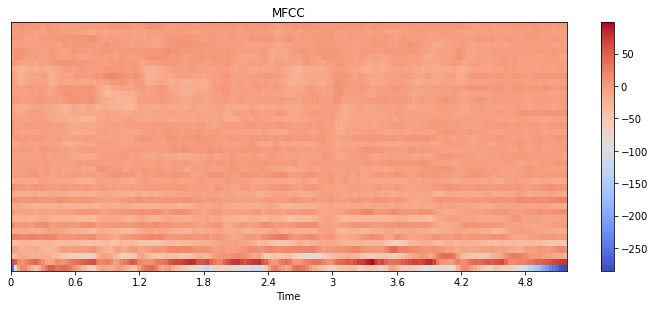

In [80]:
# Imprimir en pantalla la figura
plt.figure(figsize=(10, 8))
plt.subplot(211)
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [0]:
# Cálculo de MFCC Medio voz reverberante
mfcc_medio = np.mean(mfccs, axis=1)
mfcc_or_medio = np.mean(mfccs_or, axis=1)

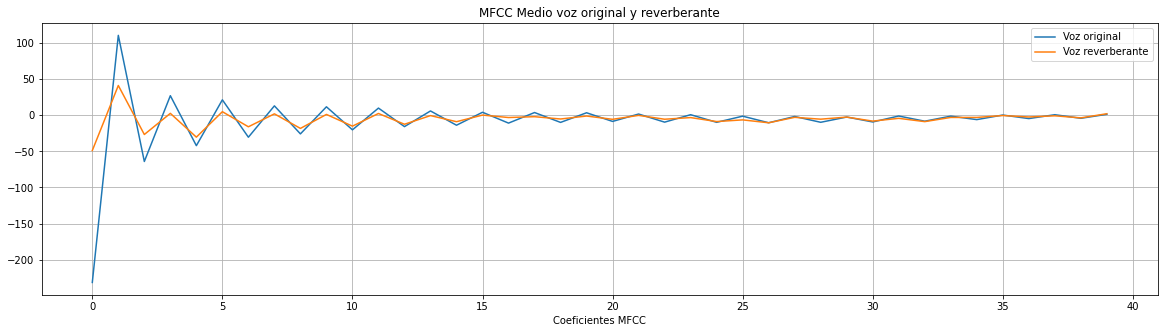

In [82]:
# Imprimir en pantalla las figuras
plt.figure(figsize=(20,5))
plt.title("MFCC Medio voz original y reverberante")
plt.plot(mfcc_or_medio, label="Voz original")
plt.plot(mfcc_medio, label="Voz reverberante")
plt.xlabel('Coeficientes MFCC')
plt.grid()
plt.legend(loc='upper right')